## Processing the Peturbseq Data with Seurat

We process data previously downloaded in `1.download-perturbseq.ipynb` using [SEURAT](https://github.com/satijalab/seurat).

> Stuart T, Butler A, Hoffman P, Hafemeister C, Papalexi E, III WMM, Hao Y, Stoeckius M, Smibert P, Satija R (2019). “Comprehensive Integration of Single-Cell Data.” Cell, 177, 1888-1902. doi: 10.1016/j.cell.2019.05.031, https://doi.org/10.1016/j.cell.2019.05.031.

We followed the standard Seurat tutorial for data quality control and normalization: https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html

In [1]:
options(repr.plot.width = 16, repr.plot.height = 10)
.libPaths()

[1] "/Users/gway/miniconda3/envs/perturbseq-processing/lib/R/library"

In [2]:
library(dplyr)
library(Seurat)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Provide directory of 10X data
gse_id <- "GSE132080"
base_dir <- file.path("data", "perturbseq")
data_dir <- file.path(base_dir, gse_id)

processed_output_file <- file.path(base_dir, paste0(gse_id, "_processed_matrix.tsv.gz"))
processed_output_file

[1] "data/perturbseq/GSE132080_processed_matrix.tsv.gz"

In [4]:
# Initialize the Seurat object
perturbseq_data <- Seurat::Read10X(data.dir = data_dir)

perturbseq <- Seurat::CreateSeuratObject(
    counts = perturbseq_data,
    project = "crispri",
    min.cells = 3,
    min.features = 200
)

perturbseq

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
20275 features across 23633 samples within 1 assay 
Active assay: RNA (20275 features, 0 variable features)

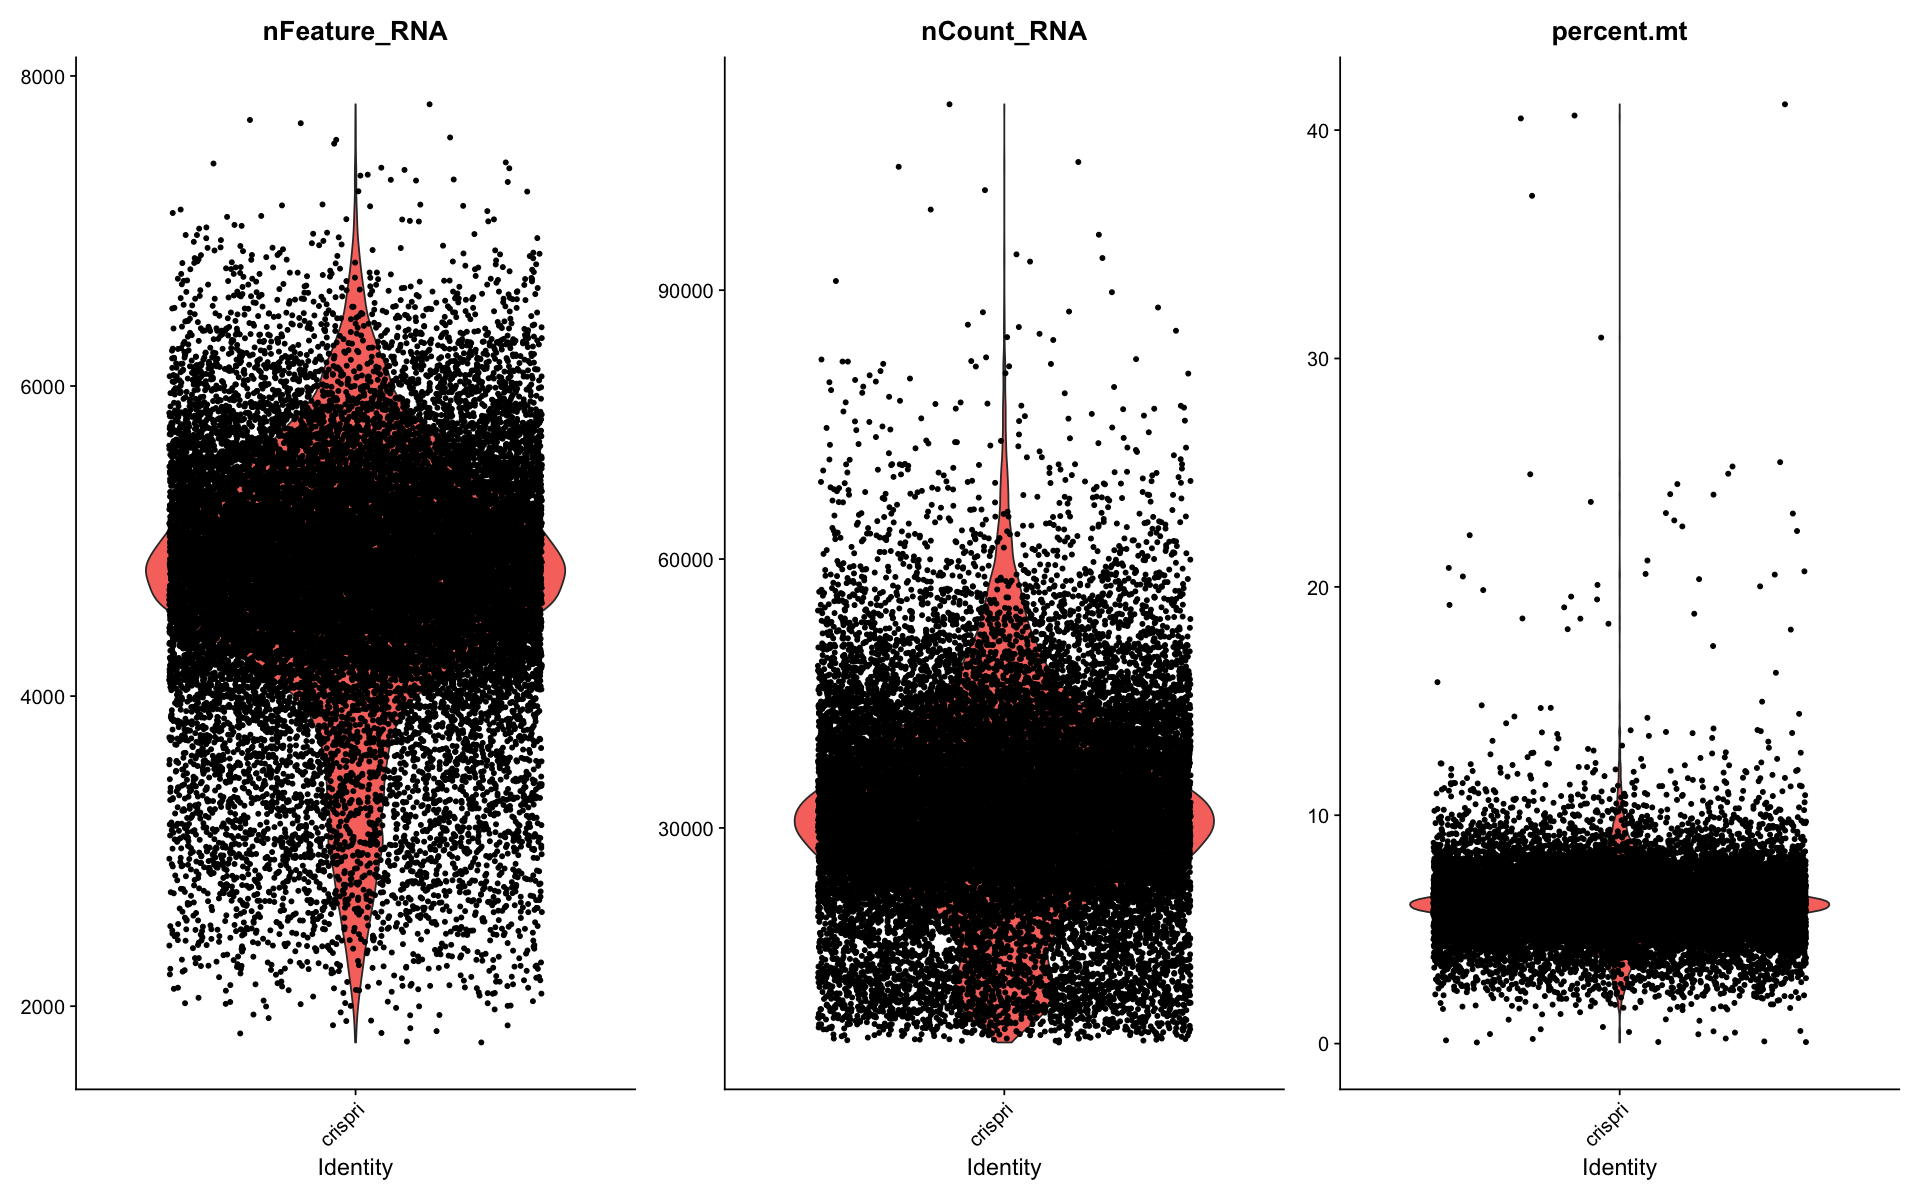

In [5]:
# Identify proportion of cells mapping to the mitochondrial genome
perturbseq[["percent.mt"]] <- Seurat::PercentageFeatureSet(perturbseq, pattern = "^MT-")

Seurat::VlnPlot(perturbseq, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

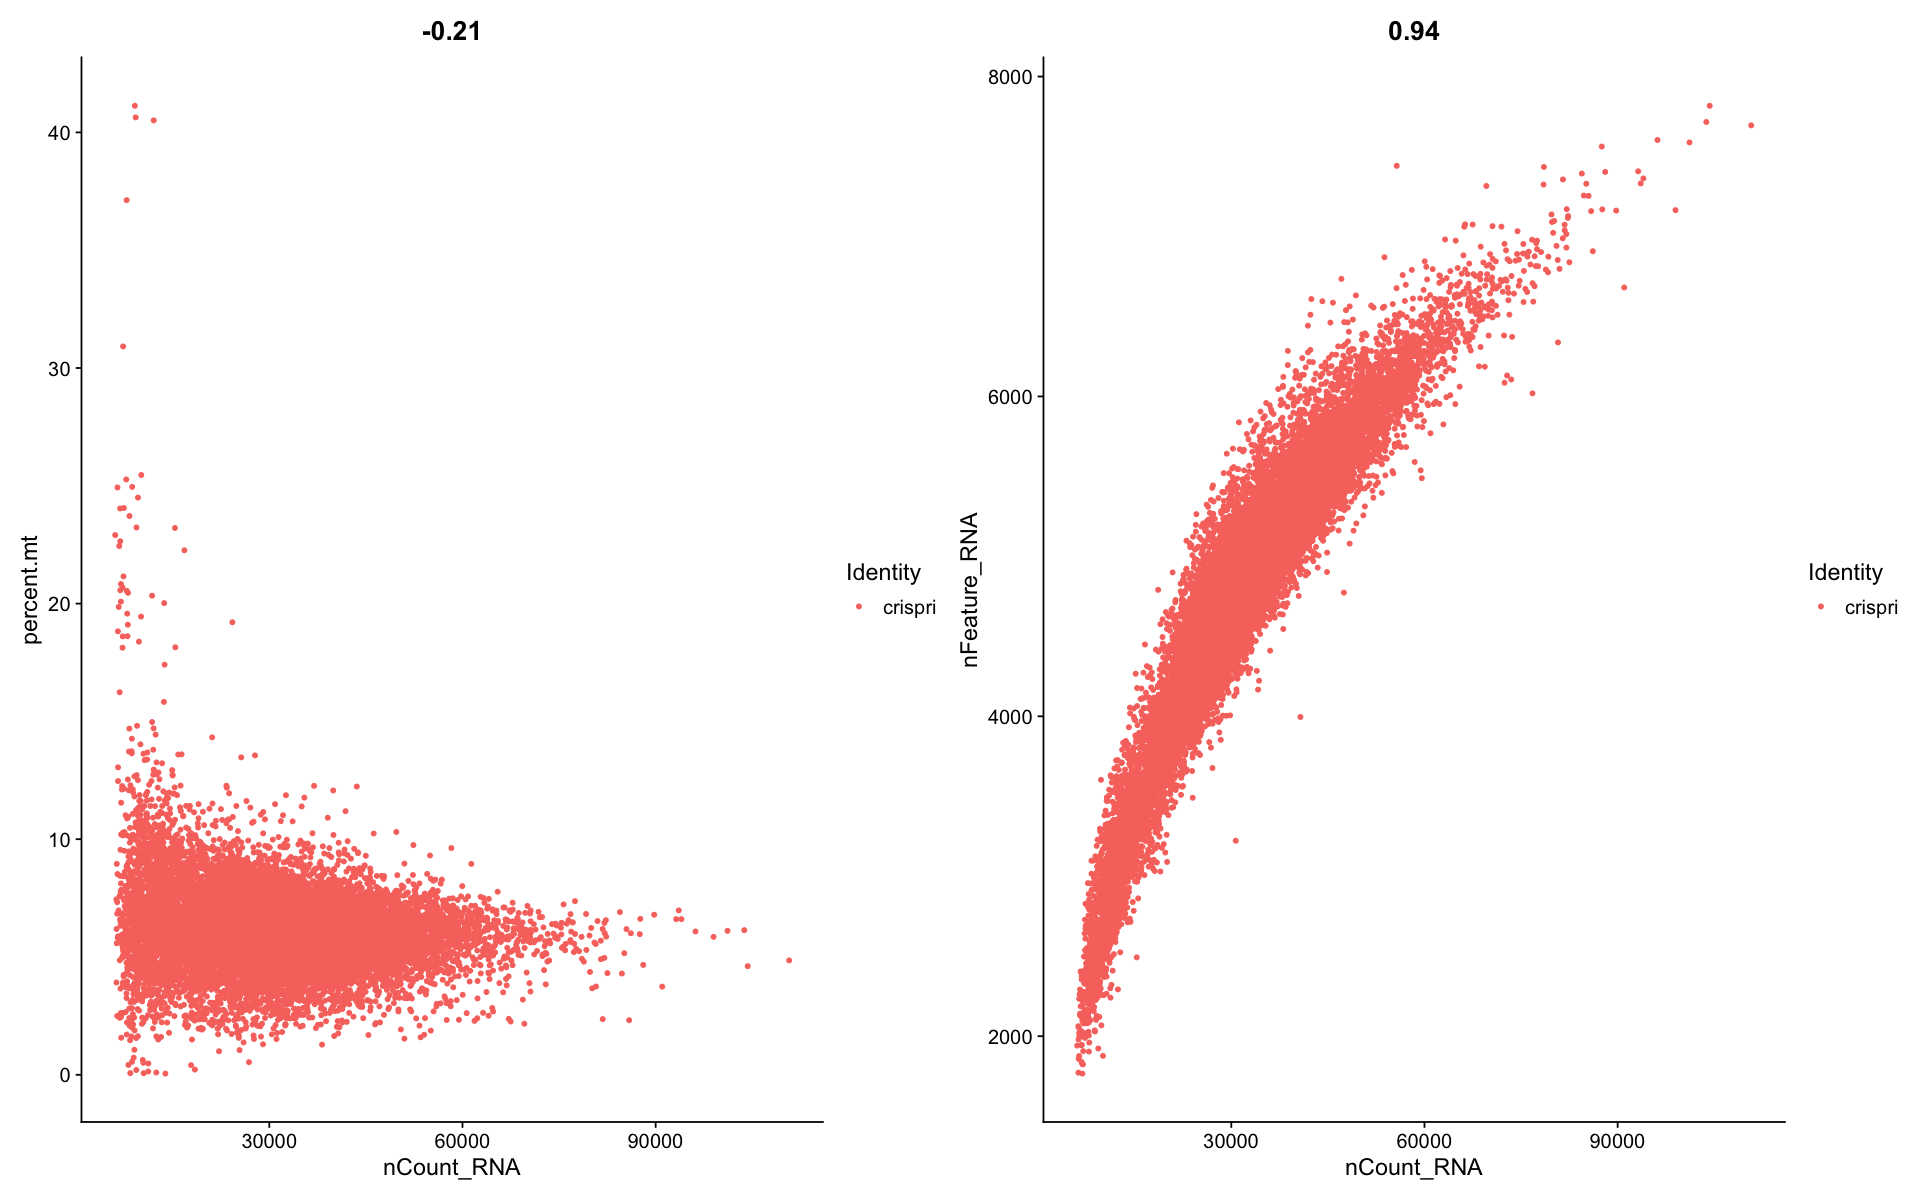

In [6]:
# Visualize relationships between counts
plot1 <- Seurat::FeatureScatter(perturbseq, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- Seurat::FeatureScatter(perturbseq, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [7]:
# Filter cells with too few and too much RNA, and cells that have outlier percentage of mito
perturbseq <- subset(
    perturbseq,
    subset = nFeature_RNA > 2000 & nFeature_RNA < 7000 & percent.mt < 15
)

In [8]:
# Normalize
perturbseq <- Seurat::NormalizeData(perturbseq, normalization.method = "LogNormalize", scale.factor = 10000)

# Find the top 2,000 most highly variable genes
perturbseq <- Seurat::FindVariableFeatures(perturbseq, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(perturbseq), 10)

top10

[1] "LTB"  "HBE1" "HBZ"  "VGF"  "CCL2" "DLK1" "ALB"  "IER3" "HBD"  "HBG2"

When using repel, set xnudge and ynudge to 0 for optimal results



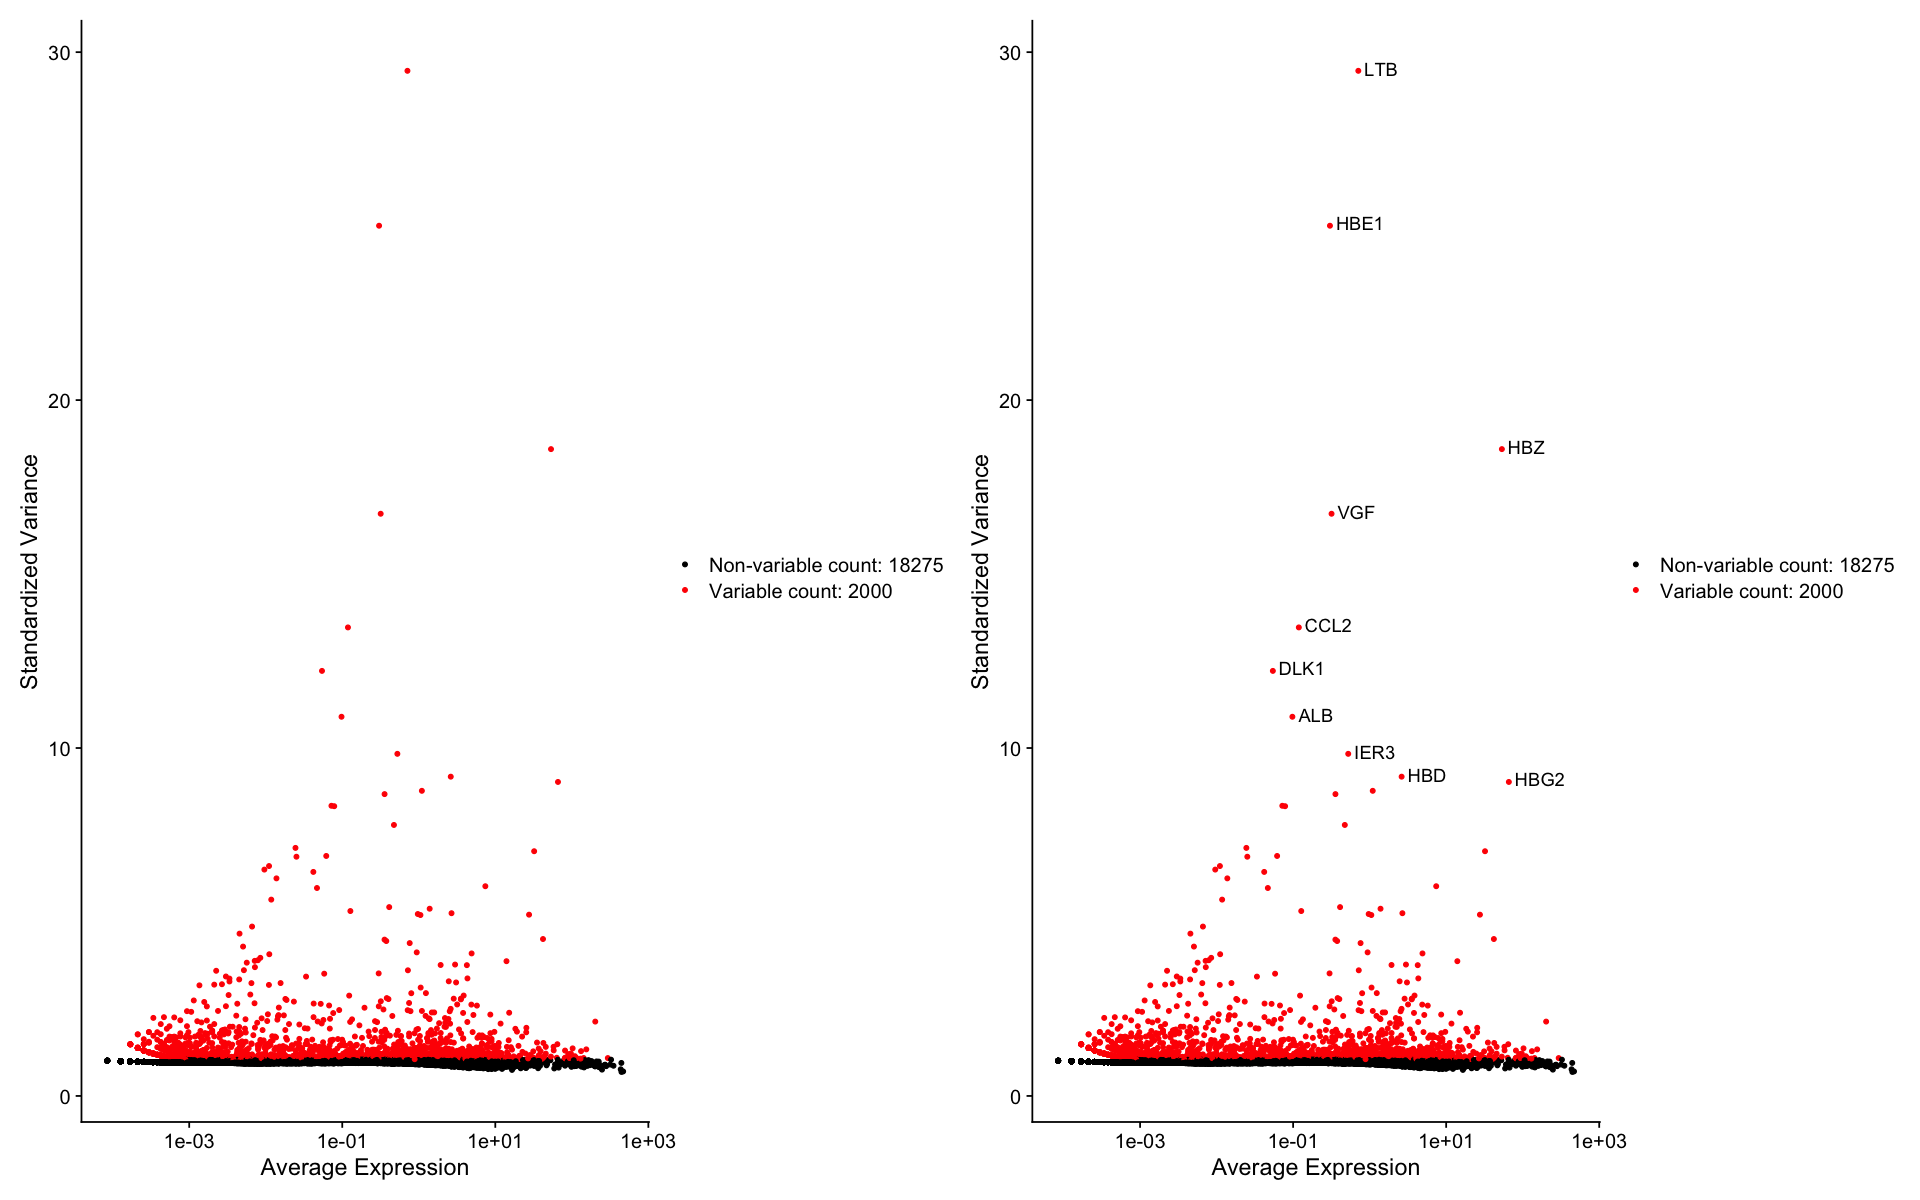

In [9]:
# Plot feature expression average and variance
plot1 <- VariableFeaturePlot(perturbseq)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

In [10]:
# Z score scale data and extract
all.genes <- rownames(perturbseq)
perturbseq <- ScaleData(perturbseq, features = all.genes)

scaled_perturbseq_data <- GetAssayData(object = perturbseq, slot = "scale.data")

dim(scaled_perturbseq_data)

Centering and scaling data matrix



[1] 20275 23537

In [11]:
# Subset to selected genes and output to file
tibble::rownames_to_column(
    as.data.frame(
        scaled_perturbseq_data[VariableFeatures(perturbseq), ]
    ),
    var = "gene"
) %>%
    readr::write_tsv(processed_output_file)